In [1]:
# to suppress indexing warning resulting from [:,None]
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import bambi
import pymc3 as pm
import arviz as az
from PIL import Image

from seaborn import despine
import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

import matplotlib.pyplot as plt
%matplotlib inline

from utils.stats import get, get_var, sem_p, center
from utils.plotting import cm2inch
from utils.general import make_sure_path_exists

# Descriptives & data

In [2]:
# directories
data_dir = '../data/'
mfx_dir = '../results/posterior_traces/regression_models/'
figure_dir = '../figures/'

# make sure output dirs exist
make_sure_path_exists(figure_dir)
make_sure_path_exists(mfx_dir)

# choice set sizes
setsizes = np.array([9, 16, 25, 36])
# colors of each set size
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']

# load response data
data = []
for setsize in setsizes:
    df_setsize = pd.read_csv(data_dir+'summary_files/setsize-{}_desc-data.csv'.format(setsize))
    df_setsize['setsize'] = setsize
    data.append(df_setsize)
data = pd.concat(data, sort=True)
data.head()

# read out subject IDs
subjects = np.sort(data.subject.unique())
n_subject = subjects.size

# load gaze data
gaze_data = []
for subject in subjects:
    for c in setsizes:
        tmp_data = pd.read_csv(data_dir+'subject_files/sub-{}_setsize-{}_desc-gazes.csv'.format(subject, c))
        gaze_data.append(tmp_data)
gaze_data = pd.concat(gaze_data, sort=True)

In [3]:
data.head()

,best_chosen,best_seen_chosen,choice,cumulative_gaze_0,cumulative_gaze_1,cumulative_gaze_10,cumulative_gaze_11,cumulative_gaze_12,cumulative_gaze_13,cumulative_gaze_14,...,stimulus_34,stimulus_35,stimulus_4,stimulus_5,stimulus_6,stimulus_7,stimulus_8,stimulus_9,subject,trial
0,1.0,1.0,1,0.072271,0.153518,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr62.png,nr125.png,nr63.png,nr113.png,nr27.png,NaN,0,2
1,1.0,1.0,0,0.074341,0.073074,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr76.png,nr93.png,nr79.png,nr4.png,nr92.png,NaN,0,3
2,1.0,1.0,1,0.068776,0.124769,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr56.png,nr91.png,nr30.png,nr106.png,nr121.png,NaN,0,7
3,1.0,1.0,3,0.133512,0.060818,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr21.png,nr85.png,nr2.png,nr58.png,nr7.png,NaN,0,9
4,1.0,1.0,4,0.060270,0.072763,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr69.png,nr81.png,nr79.png,nr58.png,nr28.png,NaN,0,14


In [4]:
gaze_data.head()

,choice,dur,gaze_num,is_first,is_last,is_last_to_choice,is_returning,item,item_value,onset,returning_gaze_count,setsize,stimulus,subject,trial
0,1,552.0,1.0,1.0,0.0,1.0,0.0,4,0.0,76.0,0.0,9,nr62.png,0,2
1,1,188.0,2.0,0.0,0.0,1.0,0.0,3,0.0,678.0,0.0,9,nr48.png,0,2
2,1,260.0,3.0,0.0,0.0,1.0,0.0,7,0.0,922.0,0.0,9,nr113.png,0,2
3,1,348.0,4.0,0.0,0.0,1.0,0.0,1,2.0,1238.0,0.0,9,nr10.png,0,2
4,1,326.0,5.0,0.0,0.0,1.0,0.0,0,0.0,1662.0,0.0,9,nr91.png,0,2


## Insert additional item attributes

### "Size" 

In [5]:
def compute_item_sizes(stimulus_images, rgb_threshold=5):
    """Compute the fraction of an image that is not black
    (ie. the snack food item). This function assumes that 
    the image background is consistently black.
    
    Args:
        stimulus_images (array): paths to stimulus images 
            for which size is to be computed
        rgb_threshold (int): defines the maximum value of
            any rgb-index that is still counted as black;
            if rgb_threshold = 5 all rgb-indeces must be < 5
                 
    Returns:
        array containing sizes for each stimulus image
    """
    # compute sizes of items, relative to image size
    relative_item_sizes = dict()
    for stimulus_image in stimulus_images:

        # load image
        im = Image.open(stimulus_image)
        colors = im.getcolors(im.size[0]*im.size[1])
        num_pixels = float(im.size[0]*im.size[1])
        # count black background pixels
        num_black_pixels = np.sum([s[0] for s in colors
                                   if np.all(np.array(s[1][:-1]) < rgb_threshold)])
        # determine size as % of image
        fraction_item = 1. - (num_black_pixels/num_pixels)
        relative_item_sizes[stimulus_image] = fraction_item

    return relative_item_sizes

In [6]:
# load image paths
image_dir = data_dir+'stimuli/'
stimulus_images = np.sort([image_dir+s for s in os.listdir(image_dir) if s.endswith('.png')])

# compute image sizes
item_sizes = compute_item_sizes(stimulus_images)

# add sizes to data
trial_stimuli = data[['stimulus_{}'.format(i)
                      for i in range(np.max(setsizes))]].values
trial_stimulus_sizes = np.array([item_sizes[image_dir+stimulus]
                                 if str(stimulus) != 'nan' else np.nan
                                 for stimulus in trial_stimuli.ravel()])
trial_stimulus_sizes = trial_stimulus_sizes.reshape(trial_stimuli.shape)
for i in range(np.max(setsizes)):
    data['item_size_{}'.format(i)] = trial_stimulus_sizes[:,i]

### "Row" and "column" positions

In [7]:
def return_row_col_pairs(setsize):
    out = []
    for row in range(np.int(np.sqrt(setsize))):
        for col in range(np.int(np.sqrt(setsize))):
            out.append((row+1, col+1)) # we start indexing at 1
    return out      

In [8]:
# get row and col indices
from itertools import combinations_with_replacement
position_mapping = dict()
for setsize in setsizes:
    position_mapping[setsize] = return_row_col_pairs(setsize)
print(position_mapping)

{9: [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)], 16: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)], 25: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)], 36: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]}


In [9]:
# insert in data
for setsize in setsizes:
    for i in range(setsize):
        data.loc[data['setsize']==setsize, 'item_row_{}'.format(i)] = position_mapping[setsize][i][0]
        data.loc[data['setsize']==setsize, 'item_column_{}'.format(i)] = position_mapping[setsize][i][1]

# Figure 3

In [10]:
def aggregate_time_gaze_data(data, gaze_data):
    """ Aggregate gaze data for each normalized 
    time bin (0-100%).
    
    Args:
        data (dataframe): choice data
        gaze_data (dataframe): gaze data
            
    Returns:
        dataframe     
    """
    
    setsizes = np.sort(data.setsize.unique())
    subjects = np.sort(data.subject.unique())
    
    time_gaze_data = pd.DataFrame()
    # iterate setsizes
    for setsize in setsizes:
        # subset
        setsize_data = data[data['setsize']==setsize].copy()
        setsize_gaze_data = gaze_data[gaze_data['setsize']==setsize].copy()

        # iterate subjects
        for subject in subjects:
            # subset
            subject_data = setsize_data[setsize_data['subject']==subject].copy()
            subject_gaze_data = setsize_gaze_data[setsize_gaze_data['subject']==subject].copy()

            # initiate containers
            is_looked_at = []
            size = []
            row = []
            column = []
            rating = []
            trial_time = []
            ms_trial_time = []
            is_returning = []
            duration = []
            gaze_num = []
            is_last = []
            trials = []
            # iterate trials
            for trial in subject_gaze_data.trial.unique():
                
                # subset
                trial_gaze_data = subject_gaze_data[subject_gaze_data['trial']== trial].copy()
                trial_gaze_positions = trial_gaze_data['item'].values.astype('int32')
                trials.append((np.ones((trial_gaze_positions.size, setsize)) * trial).ravel())
                trial_data = subject_data[subject_data['trial']==trial].copy()
                
                # extract & center item attributes
                trial_size = center(get(trial_data, 'item_size')[0][:setsize])
                trial_row = center(get(trial_data, 'item_row')[0][:setsize])
                trial_column = center(get(trial_data, 'item_column')[0][:setsize])
                trial_values = center(get(trial_data, 'item_value')[0][:setsize])

                # expand shapes to match gazes
                trial_is_looked_at = np.zeros((trial_gaze_positions.size, setsize))
                trial_is_looked_at[np.arange(trial_is_looked_at.shape[0]), trial_gaze_positions] = 1
                is_looked_at.append(trial_is_looked_at.ravel())

                size_tmp = np.ones((trial_gaze_positions.size, setsize)) * trial_size[None]
                size.append(size_tmp.ravel())

                row_tmp = np.ones_like(size_tmp) * trial_row[None]
                row.append(row_tmp.ravel())

                column_tmp = np.ones_like(size_tmp) * trial_column[None]
                column.append(column_tmp.ravel())

                rating_tmp = np.ones_like(size_tmp) * trial_values[None]
                rating.append(rating_tmp.ravel())

                is_returning_tmp = np.zeros_like(size_tmp)
                is_returning_tmp[np.arange(is_returning_tmp.shape[0]),
                                 trial_gaze_positions] = trial_gaze_data['is_returning'].values
                is_returning.append(is_returning_tmp.ravel())

                duration_tmp = np.ones_like(size_tmp) * np.asarray(trial_gaze_data['dur'].values)[:, None]
                duration.append(duration_tmp.ravel())

                trial_time_normed = np.cumsum(trial_gaze_data['dur']) / np.sum(trial_gaze_data['dur'])
                trial_time_tmp = np.ones_like(size_tmp) * trial_time_normed[:, None]
                trial_time.append(trial_time_tmp.ravel())
                
                ms_trial_time_tmp = np.ones_like(size_tmp) * np.cumsum(trial_gaze_data['dur'])[:, None]
                ms_trial_time.append(ms_trial_time_tmp.ravel())
                
                gaze_num_tmp = np.ones((trial_gaze_positions.size, setsize)) *\
                np.arange(1,len(trial_gaze_positions)+1)[:, None]
                gaze_num.append(gaze_num_tmp.ravel())
                
                is_last_tmp = np.zeros((trial_gaze_positions.size, setsize))
                is_last_tmp[-1] = 1
                is_last.append(is_last_tmp.ravel())

            # make dataframe
            time_gaze_data_tmp = pd.DataFrame()
            time_gaze_data_tmp['is_looked_at'] = np.concatenate(is_looked_at)
            # round size for numerical stability
            time_gaze_data_tmp['size'] = np.round(np.concatenate(size) * 100, 4)
            time_gaze_data_tmp['row'] = np.concatenate(row)
            time_gaze_data_tmp['column'] = np.concatenate(column)
            time_gaze_data_tmp['rating'] = np.concatenate(rating)
            time_gaze_data_tmp['is_returning'] = np.concatenate(is_returning)
            time_gaze_data_tmp['duration'] = np.concatenate(duration)
            # bin trial-time in 10% bins
            time_gaze_data_tmp['normed_time_binned'] = np.round(
                (np.concatenate(trial_time) * 100) / 10.) * 10
            time_gaze_data_tmp['normed_time'] = np.concatenate(trial_time) * 100
            time_gaze_data_tmp['ms_time'] = np.concatenate(ms_trial_time)
            time_gaze_data_tmp['gaze_num'] = np.concatenate(gaze_num)
            time_gaze_data_tmp['is_last'] = np.concatenate(is_last)
            time_gaze_data_tmp['trial'] = np.concatenate(trials)
            time_gaze_data_tmp['subject'] = subject
            time_gaze_data_tmp['setsize'] = setsize
            
            # collect
            time_gaze_data = time_gaze_data.append(time_gaze_data_tmp[['setsize',
                                                                       'subject',
                                                                       'trial',
                                                                       'is_looked_at',
                                                                       'size',
                                                                       'row',
                                                                       'column',
                                                                       'rating',
                                                                       'is_returning',
                                                                       'duration',
                                                                       'ms_time',
                                                                       'normed_time',
                                                                       'normed_time_binned',
                                                                       'gaze_num',
                                                                       'is_last']])
            
    return time_gaze_data

In [11]:
def figure_3(data,
             gaze_data,
             mfx_dir=mfx_dir+'',
             colors=['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral'],
             axs=None,
             ylims=None,
             verbose=False,
             seed=1):
    """Create figure 3 of the manuscript.
    
    Args:
        data (dataframe): choice data
        gaze_data (dataframe): gaze data   
        mfx_dir (string): mixed effects posterior trace directory
        colors (array of strings): colors to use for choice set sizes
        axs (matpltolib axis object): axis to plot onto  
        ylims (tuple of tuples): y-lims for each axis;
            must have as many entries asaxs contained in figure
        verbose (bool): whether to print mixed effect estimates to terminal
        seed (int): random seed
            
    Returns:
        matplotlib figure / axes
    """
    
    # extract setsizes/subjects
    setsizes = data.setsize.unique()
    subjects = data.subject.unique()
    
    # aggregate time-gaze-data
    time_gaze_data = aggregate_time_gaze_data(data, gaze_data)
    
    # set time bins
    time_bins = np.arange(0,105,10)
   
    # Estimate mfx model for each time bin
    n_samples = 2000
    burn = 500
    mfx_coeffs = np.zeros((time_bins.size, 6, 3))
    for ti, time_bin in enumerate(time_bins):
        
        if verbose:
            print('\nTime bin: {}'.format(time_bin))
        
        mfx_filename = 'p-item-looked-at_time-bin-{}_mfx'.format(time_bin)
        if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
            
            # reduce data to time bin
            time_bin_gaze_data = time_gaze_data[time_gaze_data['normed_time_binned']==time_bin].copy()
            # make model
            model = bambi.Model(data=time_bin_gaze_data.copy())
            # add fixed effects
            model.add('is_looked_at ~ row + column + rating + size + setsize',
                      categorical=['subject'])
            # add random effects
            model.add(random=['1|subject'])
            model.add(random=['0 + row|subject'])
            model.add(random=['0 + column|subject'])
            model.add(random=['0 + rating|subject'])
            model.add(random=['0 + size|subject'])
            model.add(random=['0 + setsize|subject'])
            
            # sample posterior
            results = model.fit(samples=n_samples,
                                tune=burn,
                                chains=2,
                                family='bernoulli',
                                backend='pymc',
                                init='ADVI',
                                n_init=50000,
                                random_seed=seed+ti)
            
            # save results
            pm.trace_to_dataframe(model.backend.trace).to_csv(
                mfx_dir+mfx_filename+'_mtrace.csv', index=False)
            az.plot_trace(results)
            plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
            summary = az.summary(results, round_to='none')
            summary.to_csv(mfx_dir+mfx_filename+'.csv')

        else:   
            if verbose:
                print('Loading pre-computed posterior trace from: '+mfx_dir)
            summary = pd.read_csv(mfx_dir+mfx_filename+'.csv'.format(time_bin), index_col='Unnamed: 0')
        
        # collect coefficients
        for vi, var in enumerate(['row', 'column', 'rating', 'size', 'setsize']):
            var_mean, var_hpd = get_var(summary, var+'[0]', verbose=verbose)
            mfx_coeffs[ti,vi, 0] = var_mean
            mfx_coeffs[ti,vi, 1:] = var_hpd
        
    # make figure
    tighten_layout = False
    if axs is None:
        tighten_layout = True
        fig, axs = plt.subplots(2,3, figsize=cm2inch(16,10), dpi=300)
        axs = axs.ravel()
    
    # plot fixed effects
    for fi, feature in enumerate(['row',  'column',  'rating', 'size']):
        # label
        axs[fi].set_ylabel(r'$\beta$'+'('+'{}'.format(feature)+')', fontsize=7)
        
        # get means & HPD
        means = mfx_coeffs[:,fi,0]
        hpds = mfx_coeffs[:,fi,1:]
        
        # plot
        axs[fi].plot(time_bins,
                     means,
                     lw=1,
                     color='black')
        axs[fi].fill_between(time_bins,
                             hpds[:,0],
                             hpds[:,1],
                             alpha=.2,
                             color='black')
        # plotting settings
        if ylims is not None:
            axs[fi].set_ylim(ylims[fi][0], ylims[fi][1])
        
    # also plot P(returning)
    axs[-2].set_ylabel('P(returning gaze)'.format(feature), fontsize=7)
    # exclude first and last 
    middle_time_gaze_data = time_gaze_data[
        np.logical_and(time_gaze_data['gaze_num']>1,
                       time_gaze_data['is_last']==0)].copy()
    # reduce to actual fixations
    middle_time_gaze_data = middle_time_gaze_data[
        middle_time_gaze_data['is_looked_at']==1].copy()
    # compute means
    means = middle_time_gaze_data.groupby(
        ['setsize',  'subject',  'trial', 'normed_time_binned'])['is_returning'].mean().groupby(
        ['setsize', 'subject', 'normed_time_binned']).mean().groupby(
        ['setsize', 'normed_time_binned']).mean()
    # compute sems
    sems = np.sqrt((means*(1-means))/means.size)
    # plot
    for si, (setsize, ls) in enumerate(zip(setsizes, ['solid', 'dotted', 'dashed', 'dashdot'])):
        axs[-2].plot(time_bins,
                     means[setsize],
                     label=setsize,
                     lw=1,
                     ls=ls,
                     color=colors[si])
        axs[-2].fill_between(time_bins,
                             means[setsize]+sems[setsize],
                             means[setsize]-sems[setsize],
                             alpha=.2,
                             color=colors[si])
    axs[-2].set_ylim(ylims[-2][0], ylims[-2][1])
    lgnd = axs[-2].legend(loc='upper left', fontsize=6, handlelength=3)   
    
    # ..and dur(returning gaze)
    axs[-1].set_ylabel('Mean duration of\nreturning gaze (ms)'.format(feature), fontsize=7)
    # exclude initial gazes to an item
    refix_time_gaze_data = middle_time_gaze_data[middle_time_gaze_data['is_returning'] == 1].copy()
    # compute means
    means = refix_time_gaze_data.groupby(
        ['setsize',  'subject',  'trial', 'normed_time_binned'])['duration'].mean().groupby(
        ['setsize', 'subject', 'normed_time_binned']).mean().groupby(
        ['setsize', 'normed_time_binned']).mean()
    # compute sems
    sems = refix_time_gaze_data.groupby(
        ['setsize', 'subject', 'trial', 'normed_time_binned'])['duration'].mean().groupby(
        ['setsize',  'subject', 'normed_time_binned']).mean().groupby(
        ['setsize', 'normed_time_binned']).sem()
    # plot
    for si, (setsize, ls) in enumerate(zip(setsizes, ['solid', 'dotted', 'dashed', 'dashdot'])):
        axs[-1].plot(time_bins,
                     means[setsize],
                     label=setsize,
                     lw=1,
                     ls=ls,
                     color=colors[si])
        axs[-1].fill_between(time_bins,
                             means[setsize]+sems[setsize],
                             means[setsize]-sems[setsize],
                             alpha=.2,
                             color=colors[si])
    axs[-1].set_ylim(ylims[-1][0], ylims[-1][1])
            
    # label axes
    for ax in axs.ravel():
        ax.set_xlabel('Normalized time (%)', fontsize=7)
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xticklabels([0, 25, 50, 75, 100])
        ax.tick_params(axis='both', which='major', labelsize=7)
        despine(ax=ax)
    
    for ax in axs.ravel()[:4]:
        ax.axhline(0, ls='--', color='k', lw=0.5)
    
    # index axes
    for label, ax in zip(list('ABCDEF'), axs):
        ax.text(-0.4, 1.05, label, transform=ax.transAxes, 
                fontsize=10, fontweight='bold', va='top')
    
    if tighten_layout:
        fig.tight_layout()
    
    return fig, axs


Time bin: 0
Loading pre-computed posterior trace from: ../results/posterior_traces/regression_models/
row[0]; Mean: -0.004988001358930796, 94% HPD: -0.0066768448509653385, -0.003347707903927557
column[0]; Mean: -0.004009610670243591, 94% HPD: -0.0053181935772277505, -0.002661447821372813
rating[0]; Mean: 0.00014134596514925622, 94% HPD: -0.0005941431269218639, 0.000904317521456986
size[0]; Mean: 7.873920478250282e-05, 94% HPD: -3.7421717092709824e-05, 0.00020761379308842853
setsize[0]; Mean: -0.001953812217450377, 94% HPD: -0.002102630125248803, -0.00181263815393347

Time bin: 10
Loading pre-computed posterior trace from: ../results/posterior_traces/regression_models/
row[0]; Mean: -0.010432947686681257, 94% HPD: -0.013393196202126423, -0.00781561252306146
column[0]; Mean: -0.0043977170157482, 94% HPD: -0.005971479411138582, -0.0028105080739713475
rating[0]; Mean: 0.0006194598216239493, 94% HPD: 0.00022405763845233007, 0.0010296110925966944
size[0]; Mean: 0.00016865644996829322, 94% H

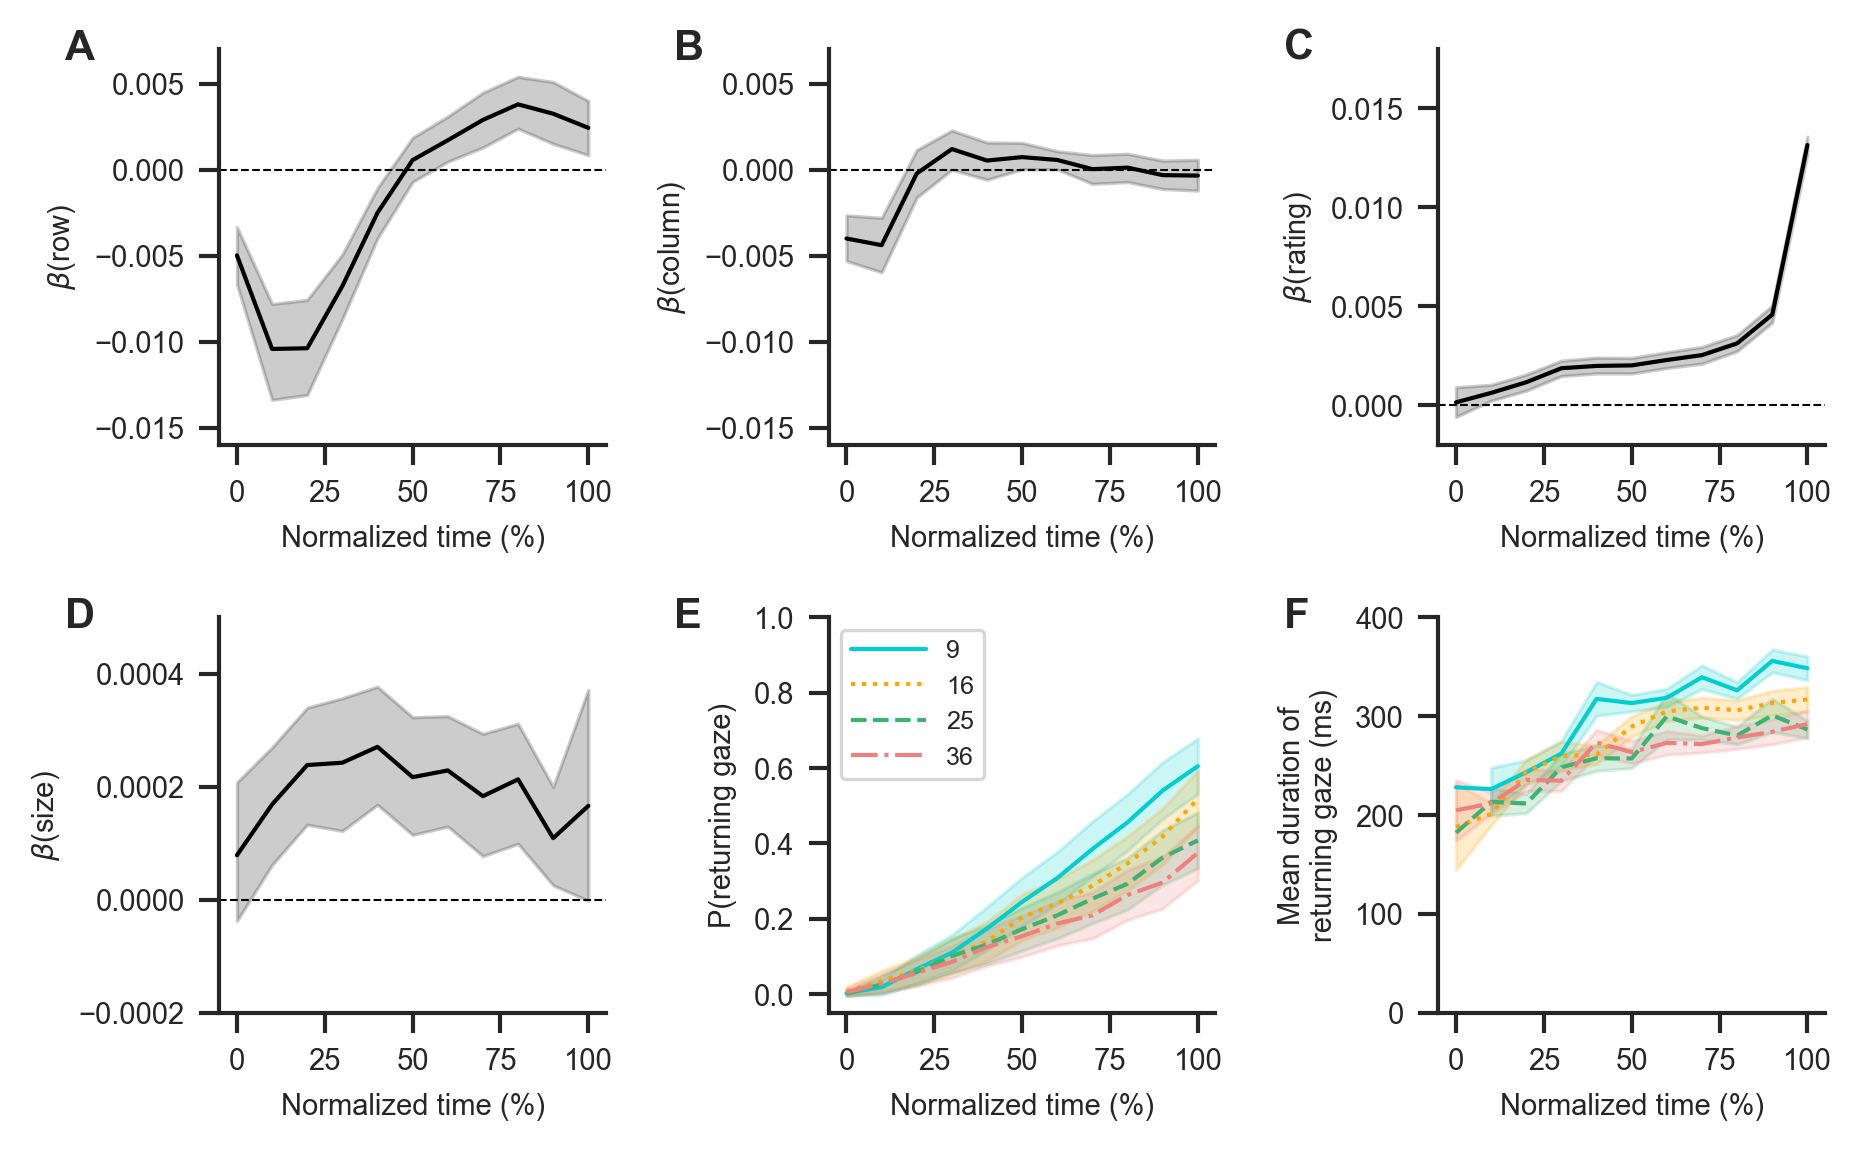

In [12]:
np.random.seed(62423)
f, _ = figure_3(data, gaze_data,
                ylims=[(-0.016, 0.007),
                       (-0.016, 0.007),
                       (-0.002, 0.018),
                       (-0.0002, 0.0005),
                       (-0.05, 1),
                       (0, 400)],
                seed=62423, verbose=True)
f.savefig(figure_dir+'Figure-3_visual-search-trajectories.pdf', dpi=300)
f.savefig(figure_dir+'Figure-3_visual-search-trajectories.jpg', dpi=300)
f.savefig(figure_dir+'Figure-3_visual-search-trajectories.png', dpi=300)

## MFX: $P(returning\_gaze) \sim time + setsize$

In [13]:
# aggregate gaze data for each time bin 0-100%
time_gaze_data = aggregate_time_gaze_data(data, gaze_data)
# exclude first and last trial gazes
time_gaze_data = time_gaze_data[np.logical_and(time_gaze_data['gaze_num']>1,
                                               time_gaze_data['is_last']==0)].copy()
# reduce to data of looked-at items
time_gaze_data = time_gaze_data[time_gaze_data['is_looked_at']==1].copy()
time_gaze_data.head()

,setsize,subject,trial,is_looked_at,size,row,column,rating,is_returning,duration,ms_time,normed_time,normed_time_binned,gaze_num,is_last
12,9,0,2.0,1.0,-9.1517,0.0,-1.0,-0.222222,0.0,188.0,740.0,11.301161,10.0,2.0,0.0
25,9,0,2.0,1.0,24.4906,1.0,0.0,-0.222222,0.0,260.0,1000.0,15.271839,20.0,3.0,0.0
28,9,0,2.0,1.0,0.3989,-1.0,0.0,1.777778,0.0,348.0,1348.0,20.586439,20.0,4.0,0.0
36,9,0,2.0,1.0,-18.2344,-1.0,-1.0,-0.222222,0.0,326.0,1674.0,25.565058,30.0,5.0,0.0
52,9,0,2.0,1.0,24.4906,1.0,0.0,-0.222222,1.0,790.0,2464.0,37.629811,40.0,6.0,0.0


In [14]:
np.random.seed(12399)
mfx_filename = 'p-returning_time_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
   
    # make model
    n_samples = 2000
    burn = 500
    model = bambi.Model(data=time_gaze_data.copy())
    # add fixed effects
    model.add('is_returning ~ ms_time + setsize', categorical=['subject'])
    # add random effects
    model.add(random=['1|subject'])
    model.add(random=['0 + ms_time|subject'])
    model.add(random=['0 + setsize|subject'])
    
    # sample posterior
    results = model.fit(samples=n_samples,
                        tune=burn,
                        family='bernoulli',
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000, 
                        random_seed=12399)
    
    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print(
        'Loading pre-computed posterior trace from: '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'ms_time[0]')
_ = get_var(summary, 'setsize[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/regression_models/
Intercept[0]; Mean: 0.15419111767623686, 94% HPD: 0.1311215332838533, 0.17786647777864692
ms_time[0]; Mean: 9.926961692942084e-05, 94% HPD: 9.217846347394508e-05, 0.00010685408766288158
setsize[0]; Mean: -0.007287282785116236, 94% HPD: -0.007962021597598195, -0.00663027085390641


## MFX: $dur(returning\_gaze) \sim time + setsize$

In [15]:
# reduce to returning gazes
refix_time_gaze_data = time_gaze_data[time_gaze_data['is_returning']==1].copy()

In [16]:
np.random.seed(97203)
mfx_filename = 'dur-returning_time_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    n_samples = 2000
    burn = 500
    model = bambi.Model(data=refix_time_gaze_data.copy())
    # add fixed effects
    model.add('duration ~ ms_time + setsize', categorical=['subject'])
    # add random effects
    model.add(random=['1|subject'])
    model.add(random=['0 + ms_time|subject'])
    model.add(random=['0 + setsize|subject'])
    
    # sample posterior
    results = model.fit(samples=n_samples,
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000, 
                        random_seed=97203)
    
    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print(
        'Loading pre-computed posterior trace from: '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract coefficient estimates
_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'ms_time[0]')
_ = get_var(summary, 'setsize[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/regression_models/
Intercept[0]; Mean: 291.83460391783217, 94% HPD: 279.2248020560828, 303.89850847947423
ms_time[0]; Mean: 0.014279836158867276, 94% HPD: 0.011777420447825256, 0.01665995036041492
setsize[0]; Mean: -2.892932213882095, 94% HPD: -3.2666241367194924, -2.5131434253640488


## MFX: $P(chose\_item) \sim value + row + column + size + setsize$

In [17]:
# collect extended gaze data for mfx model,
# containing gaze and attribures of each 
# choice set item as well as a choice indicator

ext_gaze_data = pd.DataFrame()
for setsize in setsizes:
    # subset
    setsize_data = data[data['setsize']==setsize].copy()
    
    for subject in subjects:
        # subset
        subject_data = setsize_data[setsize_data['subject']==subject].copy()
        
        # initiate containers
        size = []
        row = []
        column = []
        value = []
        cumulative_gaze = []
        is_choice = []
        trials = []
        for trial in subject_data.trial.unique():
            
            # subset
            trial_data = subject_data[subject_data['trial']==trial].copy()
            
            # get & center item attributes
            trial_size = get(trial_data, 'item_size')[0][:setsize]
            trial_row = get(trial_data, 'item_row')[0][:setsize]
            trial_column = get(trial_data, 'item_column')[0][:setsize]
            trial_values = get(trial_data, 'item_value')[0][:setsize]
            trial_cumulative_gazes = trial_data[['cumulative_gaze_{}'.format(i) for i in range(setsize)]].values.ravel()            

            # collect
            size.append(trial_size)
            row.append(trial_row)
            column.append(trial_column)
            value.append(trial_values)
            cumulative_gaze.append(trial_cumulative_gazes)

            # label choice
            is_choice_tmp = np.zeros(setsize)
            is_choice_tmp[trial_data['choice'].values[0].astype(np.int)] = 1
            is_choice.append(is_choice_tmp)

            # collect
            trials.append(np.ones(setsize) *trial)

        # make dataframe
        subject_gaze_data = pd.DataFrame()
        # scale to 0 - 100
        subject_gaze_data['size'] = np.concatenate(size) * 100
        subject_gaze_data['row'] = np.concatenate(row)
        subject_gaze_data['column'] = np.concatenate(column)
        subject_gaze_data['value'] = np.concatenate(value)
        subject_gaze_data['is_choice'] = np.concatenate(is_choice)
        # scale to 0 - 100
        subject_gaze_data['cumulative_gaze'] = np.concatenate(cumulative_gaze) * 100
        subject_gaze_data['subject'] = subject
        subject_gaze_data['setsize'] = setsize
        subject_gaze_data['trial'] = np.concatenate(trials)

        # collect
        ext_gaze_data = ext_gaze_data.append(subject_gaze_data[['setsize',
                                                                'subject',
                                                                'trial',
                                                                'size',
                                                                'row',
                                                                'column',
                                                                'value',
                                                                'cumulative_gaze',
                                                                'is_choice']])

In [18]:
np.random.seed(210380)
mfx_filename = 'p-choice_item-attributes_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):

    # make model
    samples = 2000
    burn = 500
    model = bambi.Model(data=ext_gaze_data.copy())
    # fixed effects
    model.add('is_choice ~ value + size + row + column + setsize', 
              categorical=['subject'])
    # random effects
    model.add(random=['1|subject'])
    model.add(random=['0+value|subject'])
    model.add(random=['0+size|subject'])
    model.add(random=['0+row|subject'])
    model.add(random=['0+column|subject'])
    model.add(random=['0+setsize|subject'])
    
    # sample posterior
    results = model.fit(samples=n_samples,
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000, 
                        family='bernoulli',
                        random_seed=210380)
    
    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')

else:
    print('Loading pre-computed posterior trace from: '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0') 

# extract estimates
_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'value[0]')
_ = get_var(summary, 'size[0]')
_ = get_var(summary, 'row[0]')
_ = get_var(summary, 'column[0]')
_ = get_var(summary, 'setsize[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/regression_models/
Intercept[0]; Mean: 0.09457416719924128, 94% HPD: 0.07700492655715015, 0.11191688155701884
value[0]; Mean: 0.03879853304278677, 94% HPD: 0.03528755843275692, 0.04258348915171745
size[0]; Mean: 0.0001965889167026525, 94% HPD: -0.00014566618703943157, 0.0005596922558468517
row[0]; Mean: -0.0005993886324904509, 94% HPD: -0.0012190625444521775, 0.00010534118526466588
column[0]; Mean: -0.0002846182350632643, 94% HPD: -0.0009152620764254027, 0.0003396667038585313
setsize[0]; Mean: -0.002419997133445248, 94% HPD: -0.002523029245180973, -0.002317467914869568


## MFX: $gaze \sim value + row + column + size + setsize$

In [19]:
np.random.seed(71203)
mfx_filename = 'cumulative-gaze_item-attributes_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    
    # make model
    n_samples = 2000
    burn = 500
    model = bambi.Model(data=ext_gaze_data, dropna=True)
    # fixed effects
    model.add('cumulative_gaze ~ value + size + row + column + setsize',
              categorical=['subject'])
    # random effects
    model.add(random=['1|subject'])
    model.add(random=['0+value|subject'])
    model.add(random=['0+size|subject'])
    model.add(random=['0+row|subject'])
    model.add(random=['0+column|subject'])
    model.add(random=['0+setsize|subject'])
   
    # sample posterior
    results = model.fit(samples=samples,
                        tune=burn,
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000,
                        random_seed=71203)
    
    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print(
        'Loading pre-computed posterior trace from: '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0') 

# extract estimates
_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'value[0]')
_ = get_var(summary, 'size[0]')
_ = get_var(summary, 'row[0]')
_ = get_var(summary, 'column[0]')
_ = get_var(summary, 'setsize[0]')

Loading pre-computed posterior trace from: ../results/posterior_traces/regression_models/
Intercept[0]; Mean: 7.954753464665745, 94% HPD: 7.49201536793726, 8.427457089506456
value[0]; Mean: 0.5051657942394995, 94% HPD: 0.4361871017946474, 0.5764071262763926
size[0]; Mean: 0.01726548622515766, 94% HPD: 0.00799042336717991, 0.0270467680178545
row[0]; Mean: -0.1974844131123658, 94% HPD: -0.2429373925583881, -0.15212065231595984
column[0]; Mean: -0.04368583174794908, 94% HPD: -0.07546009740542506, -0.006555881696916422
setsize[0]; Mean: -0.1771191971538682, 94% HPD: -0.1807272133236836, -0.17362583878316198
